In [72]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
import torch
import sklearn.datasets
import matplotlib.pyplot as plt

from utils.data.helpers import rotate
import os

In [74]:
# Dataset
X,y = sklearn.datasets.make_moons(n_samples=1000, noise=0.1, random_state=42)

# Normalization
X = (X - X.mean(axis=0)) / X.std(axis=0)

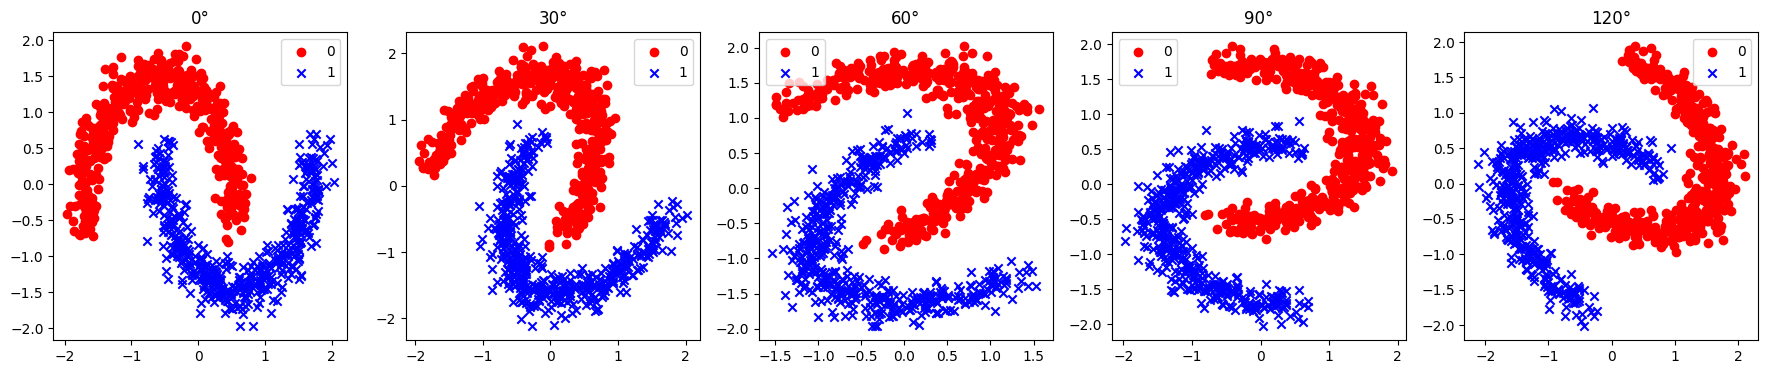

In [75]:
# Vizualization of different rotations
angles = [0, 30, 60, 90, 120]

fig, ax = plt.subplots(1, 5, figsize=(22, 4))

for i, angle in enumerate(angles):
    X_rotated = rotate(X, angle)
    ax[i].scatter(X_rotated[y==0,0], X_rotated[y==0,1], color='red', marker='o')
    ax[i].scatter(X_rotated[y==1,0], X_rotated[y==1,1], color='blue', marker='x')
    ax[i].legend(["0","1"])
    ax[i].set_title(f"{angle}°")

plt.show()

In [76]:
import yaml
from utils.config.config import get_default_dirs
from dotenv import dotenv_values

default_dirs = get_default_dirs()

config_name = "train_zoo_two_angles.yaml"
config_path = os.path.join(default_dirs["CONFIGS_DIR"], "experiments", config_name)

with open(config_path, "r") as f:
    config = yaml.safe_load(f)

env = dotenv_values(default_dirs["ENV_PATH"])
config.update(env)

In [35]:
# Train zoo

from utils.model.train import train_zoo

train_zoo(config, default_dirs["MODELS_DIR"])

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: idavron (idavron-team). Use `wandb login --relogin` to force relogin


100%|██████████| 2/2 [07:36<00:00, 228.17s/it]


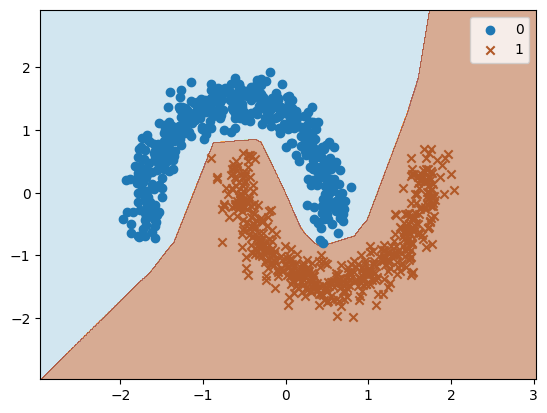

In [81]:
from utils.config.config import get_default_dirs
from utils.model.models import MLP
from utils.visualization.visualize import plot_decision_boundary

default_dirs = get_default_dirs()
models_dir = default_dirs["MODELS_DIR"]
experiment_name = config["EXPERIMENT_NAME"]

path = os.path.join(models_dir, experiment_name)
model_path = os.path.join(path, "model_0_0.pth")

model_config = config["MODEL"]
model = MLP(model_config["INPUT_DIM"], model_config["HIDDEN_DIMS"], model_config["OUTPUT_DIM"])
model.load_state_dict(torch.load(model_path))

plot_decision_boundary(model, X, y)

In [80]:
from utils.data.make_datasets import models_to_csv

models_dir = default_dirs["MODELS_DIR"]
datasets_dir = default_dirs["DATASETS_DIR"]
experiment_name = config["EXPERIMENT_NAME"]
input_dir = os.path.join(models_dir, experiment_name)
models_to_csv(input_dir, datasets_dir, config)

100%|██████████| 4000/4000 [00:41<00:00, 96.37it/s] 


True